# Pulsar Timing Variations:
When pulsars in binary systems move along eccentric orbits, their signal time of arrival (TOA) shifts.

In their book "Handbook of Pulsar Astronomy", Lorimer and Kramer (2005) explain the pulsar timing variations through the Römer delay:

## $\Delta_{RB} = x(cos(E)-e)sin(\omega) + xsin(E)\sqrt{1-e^2}cos(\omega)$

Where 

* $e$ = Eccentricity
* $\omega$ = Argument of periastron
* $E$ = Eccentric anomaly

$x$ is decribed as $x \equiv \frac{asin(i)}{c}$

With

* $s$ = Semi-major axis
* $i$ = Orbital inclination
* $c$ = Speed of light

The eccentric anomaly $E$ can be decribed in terms of the mean anomaly $M$ as

$M = E - esin(E) = \frac{2\pi}{P}(t - T_0)$

With

* $P$ = Orbital period
* $t$ = Time point on the orbit
* $T_0$ = Time at periastron

## Semi-major axis of PSR B1259-63
Given that the orbital period of PSR B1259-63 is approximately 1237 days, its mass is $1.4 M_\odot$ and that the mass of SS 2883 is approximately $22.5 M_\odot$, using Kepler's 3rd law, the semi-major axis is
# $a^3 = \frac{P^2G(M + m)}{4\pi^2}, a \sim 1396R_\odot$

With

* $G$ = Gravitational constant
* $M$ = Mass of SS 2883
* $m$ = Mass of PSR B1259-63

In [1]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import astropy.units as u
import astropy.constants as con
import ipywidgets as widgets
from IPython.display import display
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math
from scipy.optimize import fsolve

In [2]:
#Constants in cgs units
R_sun_cgs = con.R_sun.cgs.value   #Radius of sun in cgs
M_sun_cgs = con.M_sun.cgs.value   #Mass of the sun in cgs
yr_to_sec = u.yr.to(u.s)          #Year to seconds
kms_cgs = (u.km/u.s).to(u.cm/u.s) #Kms in cgs
m_p_cgs = con.m_p.cgs.value       #Mass of proton in cgs
G_cgs = con.G.cgs.value           #Gravitational constant in cgs   
k_B_cgs = con.k_B.cgs.value       #Boltzmann constant in cgs
AU_cgs = (con.au.cgs.value)       #AU in cgs
pc_to_cm = u.pc.to(u.cm)          #PC to cm
c_cgs = con.c.to(u.cm/u.s)        #Speed of light in cgs

In [3]:
def timedelay(t, P, e, a_Rsun, i, omega, T0=0):
    '''
    This function calculates the time delay of a pulsar signal along its orbit.
    -------------------------------------------------------------------------------------
    Parameters:

    t      [array] -> Time (s)
    P      [float] -> Orbital period (s)
    e      [float] -> Eccentricity
    a_Rsun [float] -> Semimajor axis (solar radii)
    i      [float] -> Orbital inclination (rad)
    omega  [float] -> Argument of Periastron (rad)
    T0     [float] -> Time at periastron (s)
    --------------------------------------------------------------------------------------
    Returns:

    The pulse time delay.
    '''
    a = a_Rsun * R_sun_cgs                                              #Converting the semimajor axis from solar radii to cm
    M = 2 * np.pi * (t-T0) / P                                          #Defining the mean anomaly
    
    #Solver function for the eccentric anomaly
    def Esolver(E, M_i, e):
        return E - e * np.sin(E) - M_i

    E = np.array([fsolve(Esolver, M_i, args=(M_i, e))[0] for M_i in M]) #Solving the eccentric anomaly in terms of mean anomaly
    x = a * np.sin(i) / c_cgs                                           #Defining the x term
    
    #Calculating the time delay
    time_delay = x * (np.cos(E)-e) * np.sin(omega) + x * np.sin(E) * np.sqrt(1-e**2) * np.cos(omega)

    return time_delay

In [4]:
def timedelay_M(t, P, e, M_sol, i, omega, T0=0):
    '''
    This function calculates the time delay of a pulsar signal along its orbit.
    -------------------------------------------------------------------------------------
    Parameters:

    t      [array] -> Time (s)
    P      [float] -> Orbital period (s)
    e      [float] -> Eccentricity
    M_sol  [float] -> Stellar mass (solar masses)
    i      [float] -> Orbital inclination (rad)
    omega  [float] -> Argument of Periastron (rad)
    T0     [float] -> Time at periastron (s)
    --------------------------------------------------------------------------------------
    Returns:

    The pulse time delay.
    '''
    M_cgs = M_sol * M_sun_cgs                                           #Converting the stellar mass from solar masses to grams
    a = ((P**2 * G_cgs * (M_cgs+1.4*M_sun_cgs))/(4*np.pi**2))**(1/3)    #Converting the semimajor axis from solar radii to cm
    M = 2 * np.pi * (t-T0) / P                                          #Defining the mean anomaly
    
    #Solver function for the eccentric anomaly
    def Esolver(E, M_i, e):
        return E - e * np.sin(E) - M_i

    E = np.array([fsolve(Esolver, M_i, args=(M_i, e))[0] for M_i in M]) #Solving the eccentric anomaly in terms of mean anomaly
    x = a * np.sin(i) / c_cgs                                           #Defining the x term
    
    #Calculating the time delay
    time_delay = x * (np.cos(E)-e) * np.sin(omega) + x * np.sin(E) * np.sqrt(1-e**2) * np.cos(omega)

    return time_delay

In [5]:
#Orbital period in seconds
P_sec = 1237*24*60*60

#Time array (5 orbits)
t = np.linspace(0, 5*P_sec, 5*512)

#Calculating the time delay
time_delay = timedelay(t=t, P=P_sec, e=0.87, a_Rsun=1396, i=np.deg2rad(24.9), omega=np.deg2rad(30))

Text(0, 0.5, 'Pulse Time Delay $(s)$')

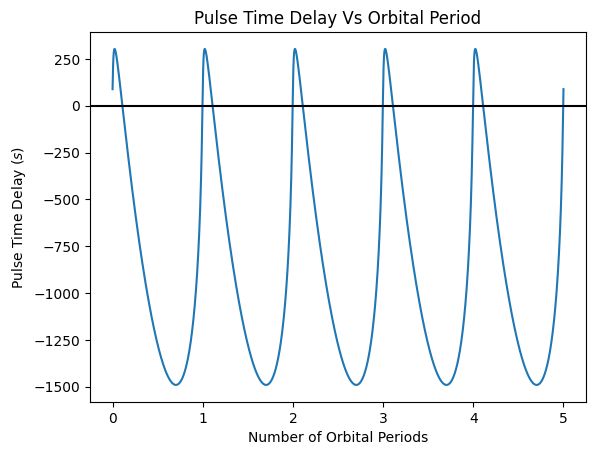

In [6]:
#Plotting
plt.plot(t/P_sec, time_delay)
plt.title('Pulse Time Delay Vs Orbital Period')
plt.axhline(y=0, color='black')
plt.xlabel('Number of Orbital Periods')
plt.ylabel('Pulse Time Delay $(s)$')

In [7]:
#Orbital period in seconds
P_sec = 7200

#Orbital time array
t = np.linspace(0, P_sec, 512)

#Calculating the time delay
time_delay = timedelay(t=t, P=P_sec, e=5e-4, a_Rsun=0.918, i=np.deg2rad(1.82), omega=np.deg2rad(0))

Text(0, 0.5, 'Pulse Time Delay $(ms)$')

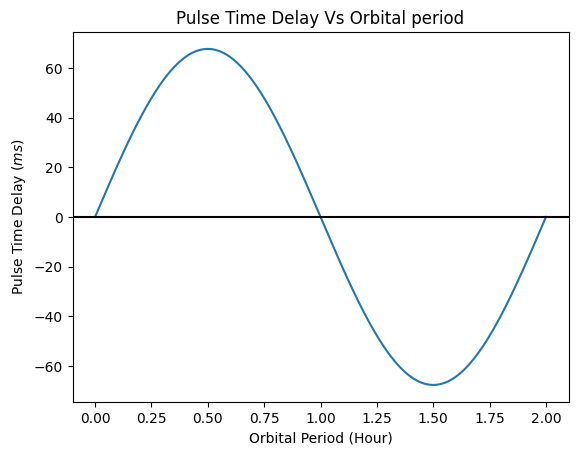

In [8]:
#Plotting
plt.plot(t/3600, time_delay*1e3)
plt.title('Pulse Time Delay Vs Orbital period')
plt.axhline(y=0, color='black')
plt.xlabel('Orbital Period (Hour)')
plt.ylabel('Pulse Time Delay $(ms)$')

In [9]:
#Orbital period in seconds
P_sec = 1237*24*60*60

#Time array (5 orbits)
t = np.linspace(0, 5*P_sec, 5*512)

#Calculating the time delay
time_delay = timedelay_M(t=t, P=P_sec, e=0.87, M_sol=22.5, i=np.deg2rad(24.9), omega=np.deg2rad(30))

Text(0, 0.5, 'Pulse Time Delay $(s)$')

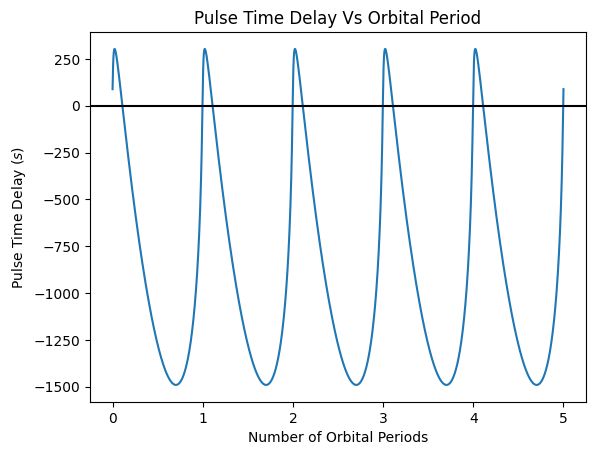

In [10]:
#Plotting
plt.plot(t/P_sec, time_delay)
plt.title('Pulse Time Delay Vs Orbital Period')
plt.axhline(y=0, color='black')
plt.xlabel('Number of Orbital Periods')
plt.ylabel('Pulse Time Delay $(s)$')

# Comparing our Model with MeerKAT data
The orbital phases are translated as
## $\phi = 2\pi(\frac{\Delta t}{P}) = 2\pi(\frac{\Delta t}{1237 days})$

# -------------------------------------------------------------------------------------------